In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# Load data from a CSV file (Replace 'data.csv' with your actual file name)
df = pd.read_csv(r"C:\SOBIN_CHACKO\TENDERS\WALES\WALES_CONTRACTS.csv")

# Display the first few rows to understand the data structure
print(df.head())

           Notice Identifier Notice Type  \
0                   MT174529    Contract   
1                   RSSB2435    Contract   
2                  DWP101976    Contract   
3  ESPO001-DN169032-84355864    Pipeline   
4                   MT179131    Contract   

                         Organisation Name  Status             Published Date  \
0                  Procurement for Housing  Closed  2016-04-18T16:45:10+01:00   
1  RAIL SAFETY AND STANDARDS BOARD LIMITED  Closed       2017-02-03T16:40:31Z   
2         DEPARTMENT FOR WORK AND PENSIONS  Closed       2017-01-20T11:41:07Z   
3                                     ESPO  Closed  2016-06-27T08:54:24+01:00   
4                        British Red Cross  Closed  2016-07-05T16:45:12+01:00   

                                               Title  \
0           Print & Multifunctional Device Solutions   
1            Audio Visual Equipment and Staging Hire   
2           DWP Document and Data Management Service   
3  7_16 Telephony, broad

C:\Users\sobin\AppData\Local\Temp\ipykernel_13472\51448626.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  awarded_df['Awarded Date'] = awarded_df['Awarded Date'].fillna(awarded_df['Published Date'])


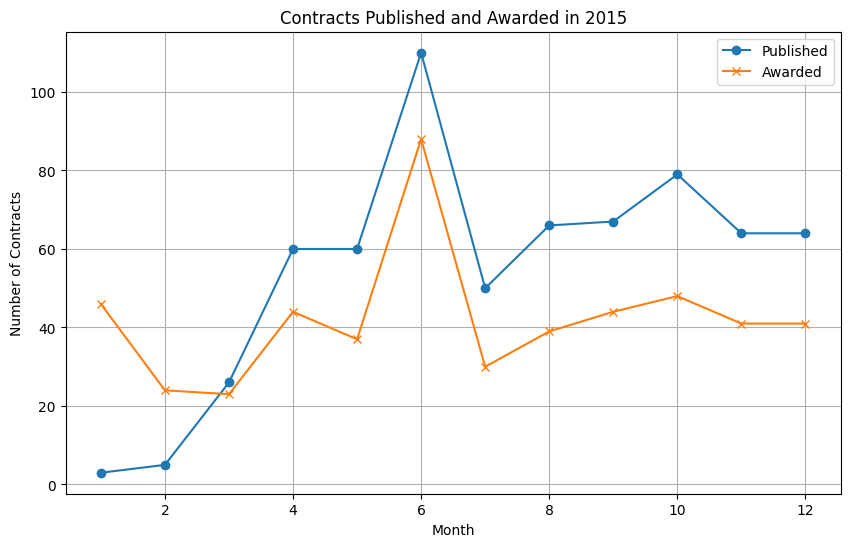

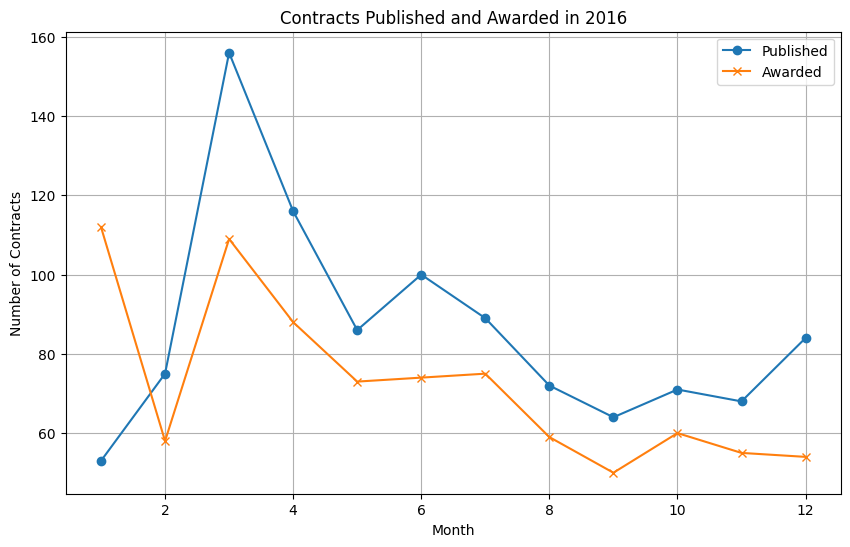

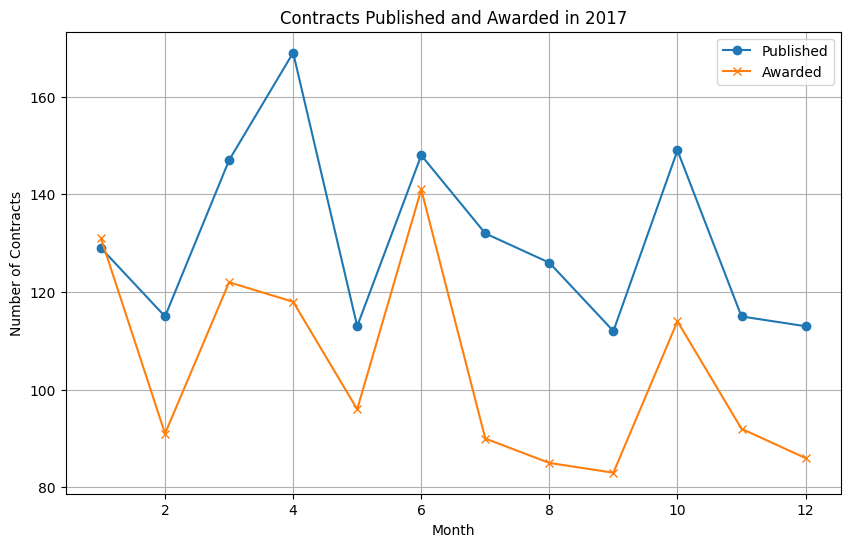

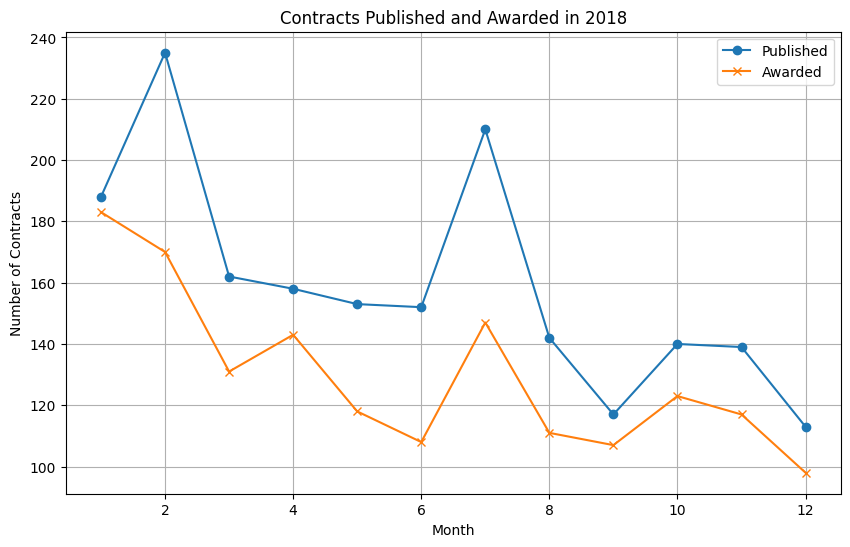

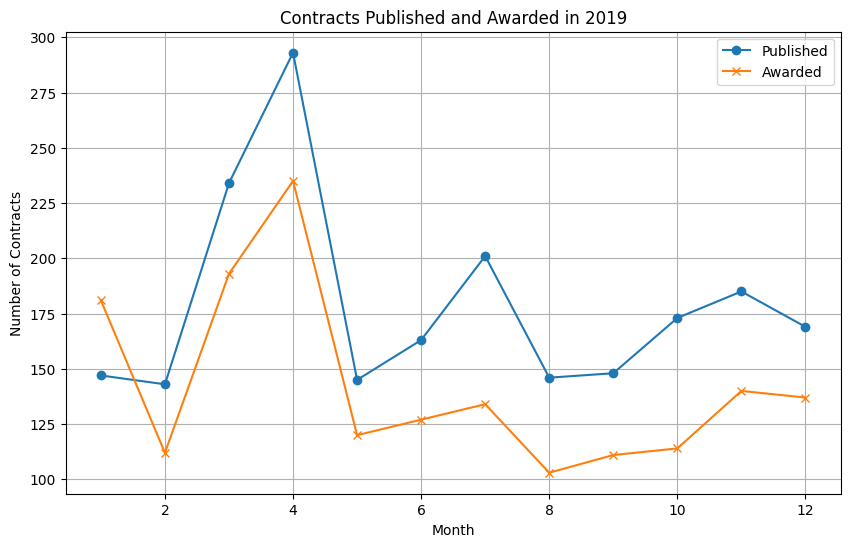

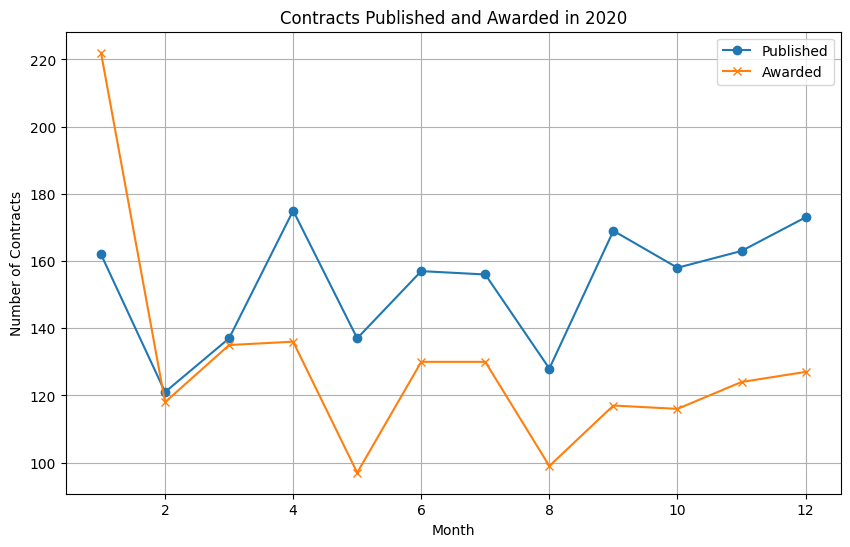

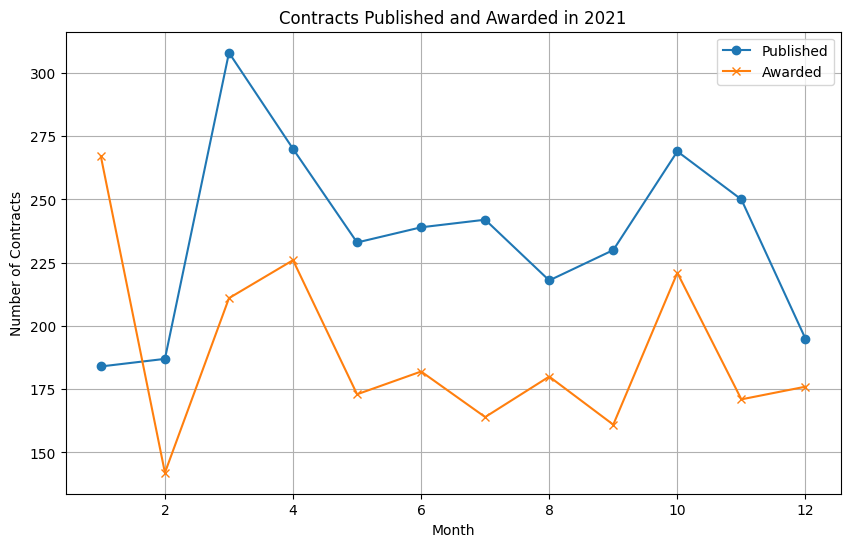

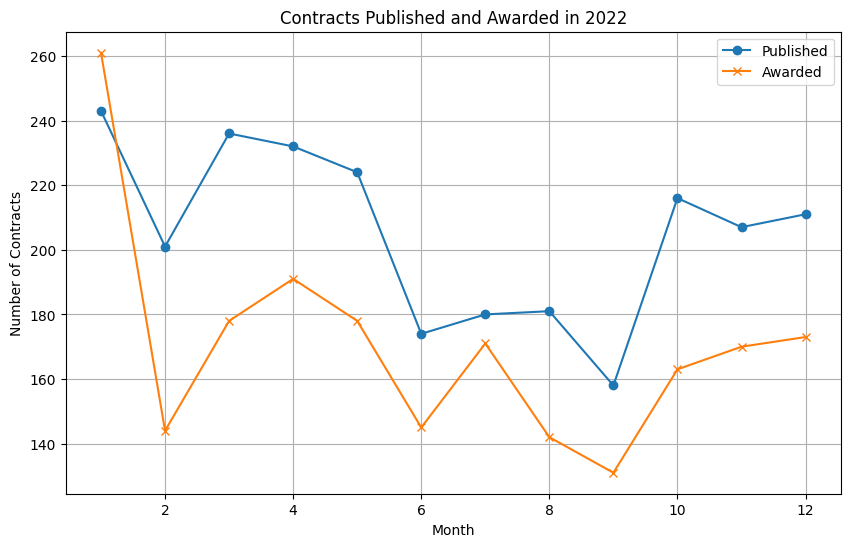

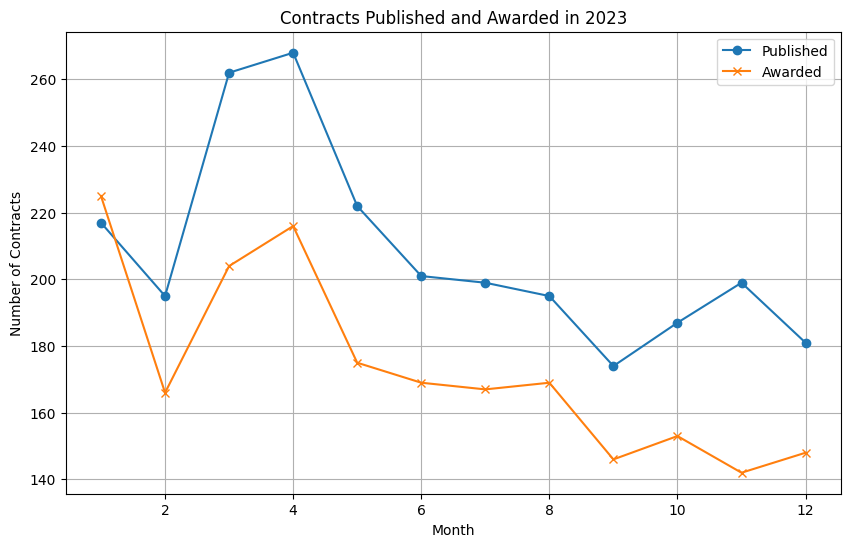

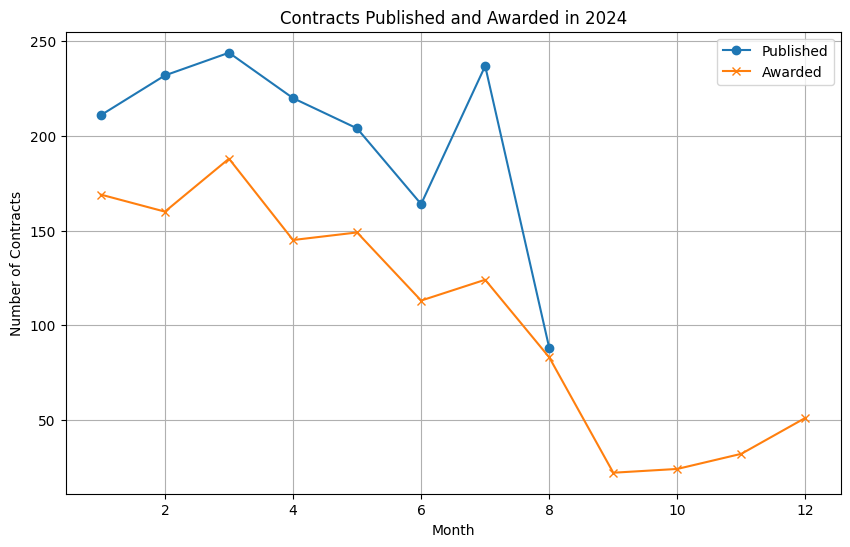

In [4]:
# Convert 'Published Date' and 'Awarded Date' to datetime, ensuring UTC timezone and proper format parsing
df['Published Date'] = pd.to_datetime(df['Published Date'], errors='coerce', utc=True)
df['Awarded Date'] = pd.to_datetime(df['Awarded Date'], errors='coerce', utc=True)

# Filter for contracts where 'Status' is 'Awarded'
awarded_df = df[df['Status'] == 'Awarded']

# Fill missing 'Awarded Date' with 'Published Date' where 'Status' is 'Awarded'
awarded_df['Awarded Date'] = awarded_df['Awarded Date'].fillna(awarded_df['Published Date'])

# Filter for data from 2015 onwards
df = df[df['Published Date'].dt.year >= 2015]

# Extract year and month for grouping
df['Published Year'] = df['Published Date'].dt.year
df['Published Month'] = df['Published Date'].dt.month
awarded_df['Awarded Year'] = awarded_df['Awarded Date'].dt.year
awarded_df['Awarded Month'] = awarded_df['Awarded Date'].dt.month

# Group and count the number of contracts published each month
published_counts = df.groupby(['Published Year', 'Published Month']).size().reset_index(name='Published Count')

# Group and count the number of contracts awarded each month
awarded_counts = awarded_df.groupby(['Awarded Year', 'Awarded Month']).size().reset_index(name='Awarded Count')

# Plotting the results
years = sorted(published_counts['Published Year'].unique())

for year in years:
    plt.figure(figsize=(10, 6))

    # Filter data for the current year
    published_data = published_counts[published_counts['Published Year'] == year]
    awarded_data = awarded_counts[awarded_counts['Awarded Year'] == year]
    
    # Plotting
    plt.plot(published_data['Published Month'], published_data['Published Count'], marker='o', label='Published')
    plt.plot(awarded_data['Awarded Month'], awarded_data['Awarded Count'], marker='x', label='Awarded')
    
    # Labels and title
    plt.xlabel('Month')
    plt.ylabel('Number of Contracts')
    plt.title(f'Contracts Published and Awarded in {year}')
    plt.legend()
    plt.grid(True)
    
    # Show the plot for the current year
    plt.show()

In [5]:
# Example strategy: Fill missing numeric values with 0 and categorical with 'Unknown'
df['Postcode'] = df['Postcode'].fillna('Unknown')
df['Value Low'] = df['Value Low'].fillna(0)
df['Value High'] = df['Value High'].fillna(0)

In [6]:
# Drop columns with excessive missing data if necessary (e.g., more than 50% missing)
df = df.dropna(thresh=len(df) * 0.5, axis=1)

          Value Low    Value High  Awarded Value  Published Year  \
count  1.853600e+04  1.853600e+04   1.513800e+04    18536.000000   
mean   1.364547e+08  1.840766e+07   2.381308e+07     2020.192922   
std    1.469933e+10  7.838953e+08   5.259504e+08        2.511115   
min    0.000000e+00  0.000000e+00   0.000000e+00     2015.000000   
25%    2.467485e+04  0.000000e+00   3.902955e+04     2018.000000   
50%    8.594700e+04  0.000000e+00   1.103769e+05     2021.000000   
75%    4.279535e+05  2.000000e+04   4.917563e+05     2022.000000   
max    2.000000e+12  1.020000e+11   5.100000e+10     2024.000000   

       Published Month  
count     18536.000000  
mean          6.200529  
std           3.377816  
min           1.000000  
25%           3.000000  
50%           6.000000  
75%           9.000000  
max          12.000000  
Tenders by Region:
 Region
Any region                                                                                                                             

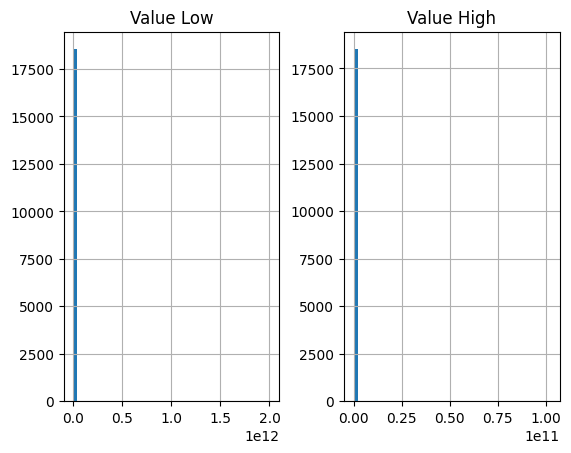

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
# Basic statistics
print(df.describe())

# Number of tenders by region
tenders_by_region = df['Region'].value_counts()
print("Tenders by Region:\n", tenders_by_region)

# Distribution of contract values
df['Value Low'] = pd.to_numeric(df['Value Low'], errors='coerce')
df['Value High'] = pd.to_numeric(df['Value High'], errors='coerce')

df[['Value Low', 'Value High']].hist(bins=50)
plt.show()

C:\Users\sobin\miniforge3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\sobin\miniforge3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


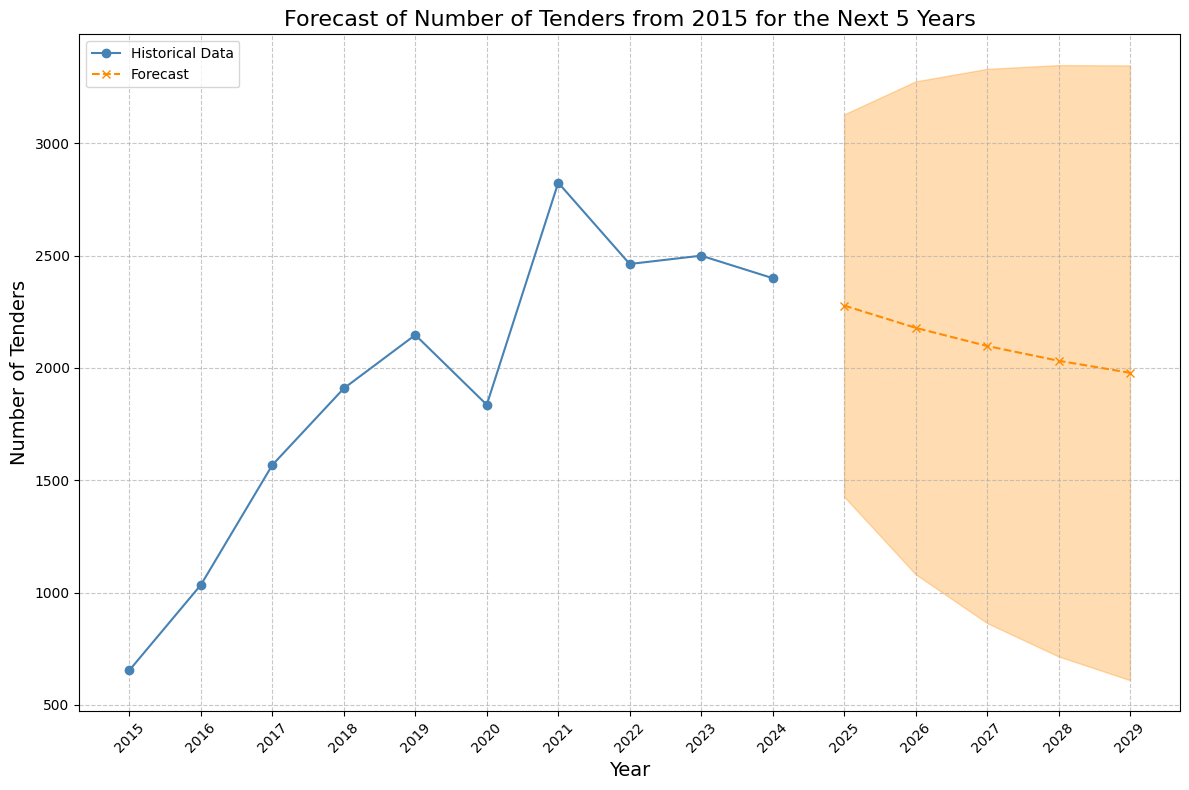

In [8]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import numpy as np

# Convert the 'Published Date' column to datetime, handling mixed time zones
df['Published Date'] = pd.to_datetime(df['Published Date'], errors='coerce', utc=True)

# Drop rows where 'Published Date' could not be converted
df = df.dropna(subset=['Published Date'])

# Extract the year from the 'Published Date' column
df['Year'] = df['Published Date'].dt.year

# Filter data to include only contracts from 2015 onwards
df = df[df['Year'] >= 2015]

# Group data by year and count the number of tenders per year
annual_data = df.groupby('Year').size()

# Adjust the count for 2024 based on the number of months available (8/12)
if 2024 in annual_data.index:
    annual_data[2024] = annual_data[2024] * (12 / 8)

# Find optimal ARIMA order
model = auto_arima(annual_data, seasonal=False)
model_fit = model.fit(annual_data)

# Predict the next 5 years
forecast, conf_int = model_fit.predict(n_periods=5, return_conf_int=True)

# Create forecast years
forecast_years = np.arange(annual_data.index[-1] + 1, annual_data.index[-1] + 6)

# Plot the historical data and the forecast
plt.figure(figsize=(12, 8))
plt.plot(annual_data.index, annual_data, label='Historical Data', color='steelblue', marker='o', linestyle='-')
plt.plot(forecast_years, forecast, label='Forecast', color='darkorange', linestyle='--', marker='x')

# Add confidence intervals
plt.fill_between(forecast_years, conf_int[:, 0], conf_int[:, 1], color='darkorange', alpha=0.3)

# Annotations and labels
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Tenders', fontsize=14)
plt.title('Forecast of Number of Tenders from 2015 for the Next 5 Years', fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(min(annual_data.index), max(forecast_years) + 1, 1), rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
import pandas as pd

# Convert 'Start Date' and 'End Date' to datetime, handling any errors
df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce', utc=True)
df['End Date'] = pd.to_datetime(df['End Date'], errors='coerce', utc=True)

# Ensure 'Status' column is of type string
df['Status'] = df['Status'].astype(str)

# Count frameworks by type and region
framework_by_region = df.groupby(['Region', 'OJEU Contract Type']).size().unstack(fill_value=0)
print("Frameworks by Region and Type:\n", framework_by_region)

# For live and upcoming frameworks, filter based on date and status
current_year = pd.Timestamp.now().year

# Filter for live frameworks
live_frameworks = df[
    (df['Status'] == 'Open') & 
    (df['Start Date'].notna()) & 
    (df['End Date'].notna()) &
    (df['Start Date'].dt.year <= current_year) &
    (df['End Date'].dt.year >= current_year)
]

# Filter for upcoming frameworks
upcoming_frameworks = df[
    (df['Status'] == 'Open') & 
    (df['Start Date'].notna()) &
    (df['Start Date'].dt.year > current_year)
]

print("Live Frameworks:\n", live_frameworks)
print("Upcoming Frameworks:\n", upcoming_frameworks)


Frameworks by Region and Type:
 OJEU Contract Type                                NotApplicable  NotSpecified  \
Region                                                                          
Any region                                                  316           178   
Any region,East Midlands,East of England                      0             0   
Any region,East Midlands,West Midlands                        0             0   
Any region,East of England                                    0             0   
Any region,London                                             0             0   
...                                                         ...           ...   
United Kingdom,United States                                  0             0   
Wales                                                       132             6   
West Midlands,London,South East,South West,Wales              0             0   
West Midlands,London,South East,Wales                         0             0

C:\Users\sobin\AppData\Local\Temp\ipykernel_13472\1426416616.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce', utc=True)
C:\Users\sobin\AppData\Local\Temp\ipykernel_13472\1426416616.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['End Date'] = pd.to_datetime(df['End Date'], errors='coerce', utc=True)


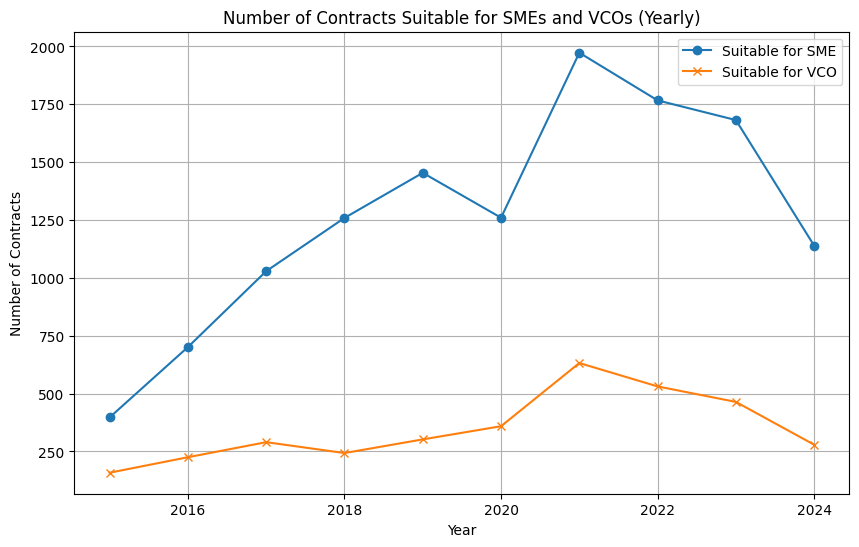

Percentage of contracts suitable for SMEs: 68.30%
Percentage of contracts suitable for VCOs: 18.79%


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame already loaded and processed

# Convert 'Published Date' to datetime if not already done
df['Published Date'] = pd.to_datetime(df['Published Date'], errors='coerce', utc=True)

# Filter for contracts from 2015 onwards
df = df[df['Published Date'].dt.year >= 2015]

# Convert 'Suitable for SME' and 'Suitable for VCO' to strings, then to boolean
df['Suitable for SME'] = df['Suitable for SME'].astype(str).str.strip().str.lower().fillna('no').apply(lambda x: x == 'yes')
df['Suitable for VCO'] = df['Suitable for VCO'].astype(str).str.strip().str.lower().fillna('no').apply(lambda x: x == 'yes')

# Add columns for the year
df['Published Year'] = df['Published Date'].dt.year

# Group by year and calculate the number of suitable contracts for SMEs and VCOs
yearly_sme_vco = df.groupby('Published Year').agg(
    Suitable_SME_Count=('Suitable for SME', 'sum'),
    Suitable_VCO_Count=('Suitable for VCO', 'sum')
).reset_index()

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(yearly_sme_vco['Published Year'], yearly_sme_vco['Suitable_SME_Count'], marker='o', label='Suitable for SME')
plt.plot(yearly_sme_vco['Published Year'], yearly_sme_vco['Suitable_VCO_Count'], marker='x', label='Suitable for VCO')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Number of Contracts')
plt.title('Number of Contracts Suitable for SMEs and VCOs (Yearly)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Print the results (as requested in the initial code)
total_contracts = df.shape[0]
suitable_for_sme = df['Suitable for SME'].sum()
suitable_for_vco = df['Suitable for VCO'].sum()
suitable_for_sme_percentage = (suitable_for_sme / total_contracts) * 100
suitable_for_vco_percentage = (suitable_for_vco / total_contracts) * 100

print(f'Percentage of contracts suitable for SMEs: {suitable_for_sme_percentage:.2f}%')
print(f'Percentage of contracts suitable for VCOs: {suitable_for_vco_percentage:.2f}%')
